In [2]:
%matplotlib inline
import numpy as np
from skyfield.api import load
from scipy.optimize import newton
from matplotlib import pyplot as plt
import pandas as pd
import plotly
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
from footprint import *
from tno_models import trojan, plutino, twotino, fourone
init_notebook_mode(connected=True)
planets = load('de423.bsp')
plotly.tools.set_credentials_file(username='sevenlin123', api_key='vhjhhsCHepMx5oQGJPEp')

In [3]:
def kep_to_xyz(a, e, i, arg, node, M):
    # compute eccentric anomaly
    f = lambda E, M, e: E - e * np.sin(E) - M
    E0 = M
    E = newton(f, E0, args=(M, e))
    # compute true anomaly
    v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
    # compute the radius
    r = a * (1 - e*np.cos(E))
    # compute X,Y,Z
    X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
    Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
    Z = r * (np.sin(i) * np.sin(arg + v))
    return X, Y, Z

In [4]:
xn, yn, zn = zip(*map(kep_to_xyz, 30+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))
x45, y45, z45 = zip(*map(kep_to_xyz, 45+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))

In [5]:
def buildmap(obj_ra, obj_dec, ecliptic_plots=True):
    lon, lat = define_footprint(ecliptic_plots=ecliptic_plots) 
    lon2, lat2 = define_footprint(polydef='round13-poly.txt', ecliptic_plots=ecliptic_plots) 
    m = Basemap(lon_0=0, projection='moll', celestial=True)
    x, y = m( lon, lat )
    x2,y2 = m(lon2, lat2)
    xy = zip(x,y)
    xy2 = zip(x2,y2)
    foot = patches.Polygon( xy, facecolor='cornflowerblue', edgecolor=None, alpha=0.4 )
    foot2 = patches.Polygon( xy2, facecolor='lightpink', edgecolor=None, alpha=0.4 )
    plt.gca().add_patch(foot)
    plt.gca().add_patch(foot2)
    fields = SNfields()
    for f in fields:
        if ecliptic_plots:
            ecl = ephem.Ecliptic(ephem.Equatorial(f.a_ra, f.a_dec))
            lon = ecl.lon if ecl.lon<ephem.degrees('180') else ecl.lon-2*np.pi    
            m.tissot(lon*180/np.pi, ecl.lat*180/np.pi, 1.05, 100, facecolor='g', alpha=0.5)
        else:
            ra = f.a_ra if f.a_ra<ephem.degrees('180') else f.a_ra-2*np.pi
            m.tissot(ra*180/np.pi, f.a_dec*180/np.pi, 1.05, 100, facecolor='r', alpha=0.5)
    obj_ra = obj_ra*180/np.pi
    obj_dec = obj_dec*180/np.pi
    for i in range(len(obj_ra)):
        m.scatter(obj_ra[i], obj_dec[i],3,marker='.',color='k', latlon=True)
    m.drawmapboundary()
    parallels = np.arange(-180.,181,20.)
    m.drawparallels(parallels,labels=[False,True,True,False], alpha=0.4)
    meridians = np.arange(-180.,181.,20.)
    m.drawmeridians(meridians, alpha=0.4)
    return m

plt.figure(figsize=(20,10))
m = buildmap(p.ra, p.dec, ecliptic_plots=False)

In [87]:
t = trojan(size = 5000, mjd=59154, i_sigma = 12)

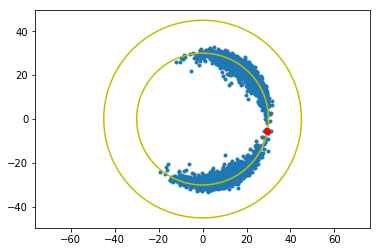

In [7]:
plt.axis('equal')
plt.scatter(t.X,t.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(t.x_n, t.y_n, 'ro')

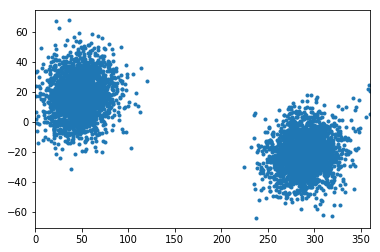

In [8]:
plt.xlim(0,360)
#t.ra[t.ra > np.pi] -= 2*np.pi
plt.plot(t.ra*180/np.pi, t.dec*180/np.pi, '.')

/Users/edward/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3223: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

/Users/edward/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3232: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.



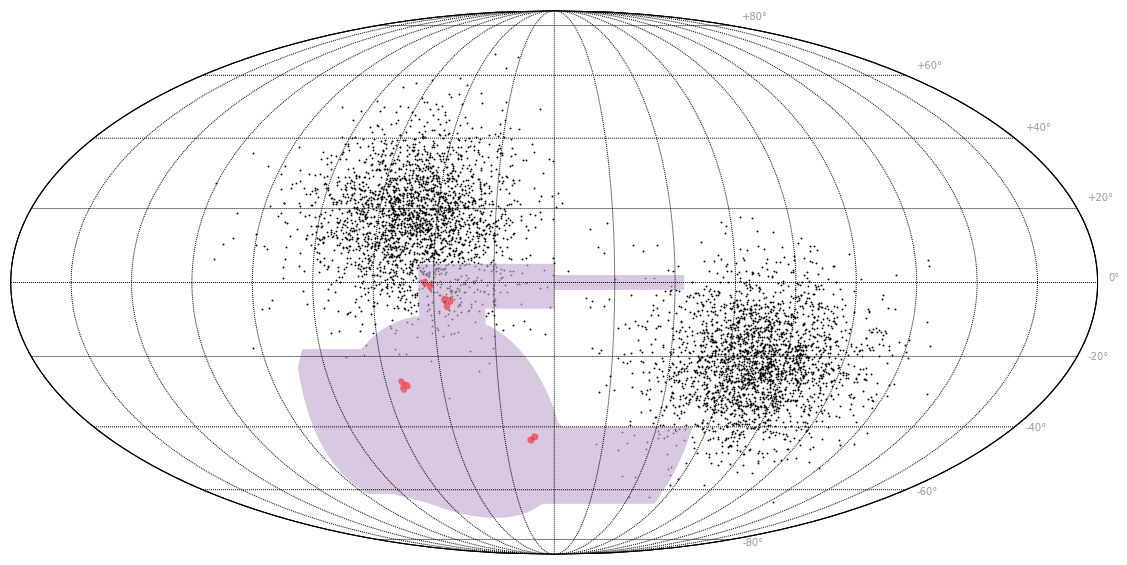

In [9]:
plt.figure(figsize=(20,10))
m = buildmap(t.ra, t.dec, ecliptic_plots=False)

In [10]:
BC = np.loadtxt('radec_BC.list')
BD = np.loadtxt('radec_BD.list')
BH = np.loadtxt('radec_BH.list')
BL = np.loadtxt('radec_BL.list')
BS = np.loadtxt('radec_BS.list')
BT = np.loadtxt('radec_BT.list')
ma = np.loadtxt('radec_ma.list')

In [67]:
def buildmap(obj_ra, obj_dec, ecliptic_plots=True):
    plt.figure(figsize=(20,10))
    m = Basemap(lon_0=0, projection='moll', celestial=True)
    plane_lon = np.arange(-np.pi, np.pi, .1*np.pi/180.)
    plane_lat = np.zeros(len(plane_lon))
    plane_p15 = np.zeros(len(plane_lon))+12*np.pi/180.
    plane_m15 = np.zeros(len(plane_lon))-12*np.pi/180.
    ecl_plane = np.zeros([len(plane_lat), 2])
    ecl_plane_p15 = np.zeros([len(plane_lat), 2])
    ecl_plane_m15 = np.zeros([len(plane_lat), 2])
    gal_plane = np.zeros([len(plane_lat), 2])
    for i in range(len(plane_lat)):
        ecl_plane[i] = ephem.Equatorial(ephem.Ecliptic(plane_lon[i], plane_lat[i])).get()
        ecl_plane_p15[i] = ephem.Equatorial(ephem.Ecliptic(plane_lon[i], plane_p15[i])).get()
        ecl_plane_m15[i] = ephem.Equatorial(ephem.Ecliptic(plane_lon[i], plane_m15[i])).get()
        gal_plane[i] = ephem.Equatorial(ephem.Galactic(plane_lon[i], plane_lat[i])).get()
        m.scatter(gal_plane[i][0]*180/np.pi, gal_plane[i][1]*180/np.pi,1,marker='o',color='steelblue', latlon=True)
        
    m.scatter(ecl_plane.T[0]*180/np.pi, ecl_plane.T[1]*180/np.pi,3,marker='o',color='darkorange', latlon=True)
    m.scatter(ecl_plane_p15.T[0]*180/np.pi, ecl_plane_p15.T[1]*180/np.pi,1,marker='.',color='orange', latlon=True)
    m.scatter(ecl_plane_m15.T[0]*180/np.pi, ecl_plane_m15.T[1]*180/np.pi,1,marker='.',color='orange', latlon=True)

    obj_ra = obj_ra*180/np.pi
    obj_dec = obj_dec*180/np.pi
    for i in range(len(obj_ra)):
        m.scatter(obj_ra[i], obj_dec[i],3,marker='.',color='k', latlon=True, alpha=0.3)
       
    m.drawmapboundary()
    parallels = np.arange(-180.,181,20.)
    m.drawparallels(parallels,labels=[False,True,True,False], alpha=0.8)
    meridians = np.arange(-180.,181.,20.)
    m.drawmeridians(meridians, alpha=0.4)
    plt.legend(fontsize = 16, loc = 4)
    return m

<Figure size 1440x720 with 0 Axes>

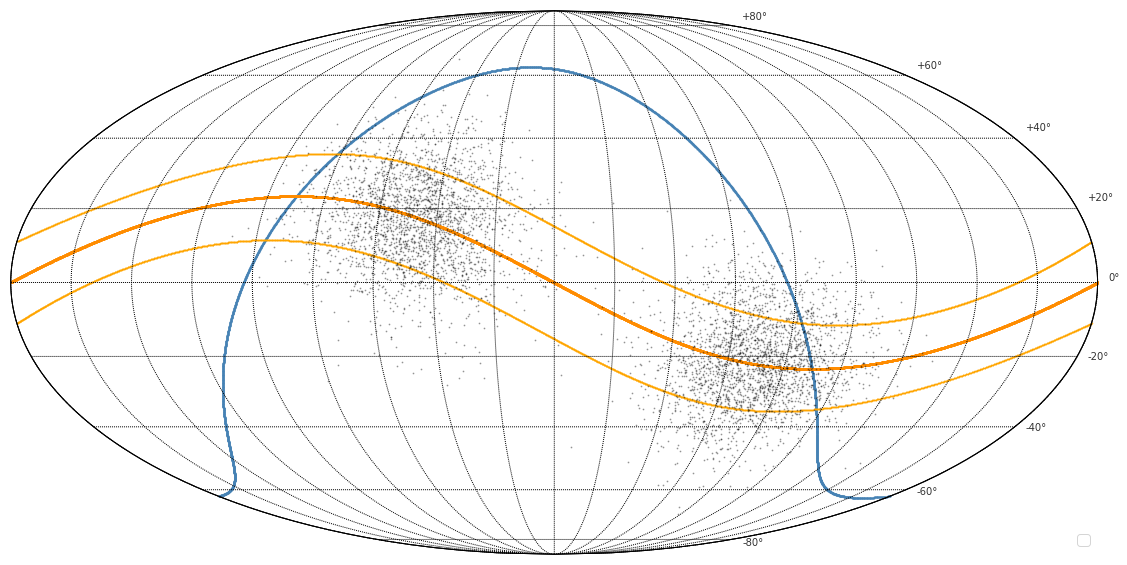

In [68]:
plt.figure(figsize=(20,10))
m = buildmap(t.ra, t.dec, ecliptic_plots=False)

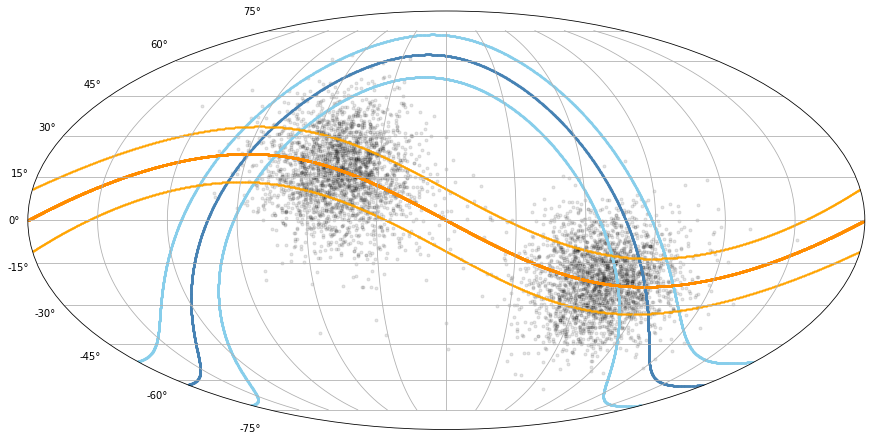

In [88]:
def radec2project(ra, dec):
    ra[ra>180] -= 360
    return (-np.radians(ra), np.radians(dec))

fig = plt.figure(figsize=(15, 8))
ax = plt.subplot(111, projection="mollweide")
x, y = radec2project(t.ra*180/np.pi, t.dec*180/np.pi)
ax.scatter(x, y, marker='.',color='k', alpha=0.1)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
#ax.get_xaxis().set_visible(False)
plane_lon = np.arange(-np.pi, np.pi, .1*np.pi/180.)
plane_lat = np.zeros(len(plane_lon))
plane_p15 = np.zeros(len(plane_lon))+10*np.pi/180.
plane_m15 = np.zeros(len(plane_lon))-10*np.pi/180.
ecl_plane = np.zeros([len(plane_lat), 2])
ecl_plane_p15 = np.zeros([len(plane_lat), 2])
ecl_plane_m15 = np.zeros([len(plane_lat), 2])
gal_plane = np.zeros([len(plane_lat), 2])
gal_plane_p10 = np.zeros([len(plane_lat), 2])
gal_plane_m10 = np.zeros([len(plane_lat), 2])
for i in range(len(plane_lat)):
    ecl_plane[i] = ephem.Equatorial(ephem.Ecliptic(plane_lon[i], plane_lat[i])).get()
    ecl_plane_p15[i] = ephem.Equatorial(ephem.Ecliptic(plane_lon[i], plane_p15[i])).get()
    ecl_plane_m15[i] = ephem.Equatorial(ephem.Ecliptic(plane_lon[i], plane_m15[i])).get()
    gal_plane[i] = ephem.Equatorial(ephem.Galactic(plane_lon[i], plane_lat[i])).get()
    gal_plane_p10[i] = ephem.Equatorial(ephem.Galactic(plane_lon[i], plane_p15[i])).get()
    gal_plane_m10[i] = ephem.Equatorial(ephem.Galactic(plane_lon[i], plane_m15[i])).get()

    
    
x, y = radec2project(gal_plane.T[0]*180/np.pi, gal_plane.T[1]*180/np.pi)
ax.scatter(x, y,1,marker='o',color='steelblue') 
x, y = radec2project(gal_plane_p10.T[0]*180/np.pi, gal_plane_p10.T[1]*180/np.pi)
ax.scatter(x, y,1,marker='o',color='skyblue') 
x, y = radec2project(gal_plane_m10.T[0]*180/np.pi, gal_plane_m10.T[1]*180/np.pi)
ax.scatter(x, y,1,marker='o',color='skyblue') 
x, y = radec2project(ecl_plane.T[0]*180/np.pi, ecl_plane.T[1]*180/np.pi)
ax.scatter(x, y,3,marker='o',color='darkorange')
x, y = radec2project(ecl_plane_p15.T[0]*180/np.pi, ecl_plane_p15.T[1]*180/np.pi)
ax.scatter(x, y ,1,marker='.',color='orange')
x, y = radec2project(ecl_plane_m15.T[0]*180/np.pi, ecl_plane_m15.T[1]*180/np.pi)
ax.scatter(x, y ,1,marker='.',color='orange')
plt.grid(True)
plt.savefig('neptune_trojan_2020.pdf')

In [ ]:
two = twotino(size = 5000, mjd=57023, amp_c = 3, amp_max = 5, amp_min = 0)

In [ ]:
plt.hist((two.i)*180/np.pi, bins = 20)

In [ ]:
plt.hist((two.phi+two.lambda_N)%(2*np.pi)*180/np.pi, bins = 20)

In [ ]:
plt.yscale('log')
plt.hist(t.mag_r, bins = 20)

In [ ]:
plt.axis('equal')
plt.scatter(two.X[two.phi0 == 0],two.Y[two.phi0 == 0], marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(two.x_n, two.y_n, 'ro')

In [ ]:
plt.axis('equal')
plt.scatter(two.X[two.phi0 != 0],two.Y[two.phi0 != 0], marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(two.x_n, two.y_n, 'ro')

In [ ]:
plt.axis('equal')
plt.scatter(two.X,two.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(two.x_n, two.y_n, 'ro')

In [ ]:
twotinos = Scatter3d(x=two.X, y=two.Y, z=two.Z, mode='markers', marker=dict(size=1, symbol='circle'), opacity=0.7, name='twotinos')
sun = Scatter3d(x=0, y=0, z=0, mode='markers', marker=dict(size=10, symbol='circle'), opacity=1, name='Sun')
neptune = Scatter3d(x=two.x_n, y=two.y_n, z=two.z_n, mode='markers', marker=dict(size=5, symbol='circle'), opacity=0.7, name ='Neptune')
fig = Figure(data=[twotinos, sun, neptune])
py.iplot(fig)

In [ ]:
plt.figure(figsize=(20,10))
m = buildmap(two.ra[two.phi0 == 0], two.dec[two.phi0 == 0], ecliptic_plots=False)

In [ ]:
plt.figure(figsize=(20,10))
m = buildmap(two.ra[two.phi0 != 0], two.dec[two.phi0 != 0], ecliptic_plots=False)

In [ ]:
f = fourone(size = 5000, mjd=57023, amp_c = 0, amp_max = 0, amp_min = 0, i_sigma = 1)

In [ ]:
plt.axis('equal')
plt.scatter(f.X,f.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(f.x_n, f.y_n, 'ro')